# Benchmarking

# Using QPCA class

In [1]:
from QPCA._decomposition.Qpca import QPCA
import numpy as np
import matplotlib.pyplot as plt
import random
from QPCA._preprocessingUtilities.preprocessing_matrix_utilities import generate_matrix

In [2]:
resolution=2
matrix_dimension=2
lista=list(range(0,2**resolution))
eigenvalues_list=random.sample(lista,matrix_dimension)
eigenvalues_list

[3, 2]

In [3]:
input_matrix=generate_matrix(matrix_dimension=matrix_dimension,replicate_paper=False,seed=1235,eigenvalues_list=eigenvalues_list)

Matrix:
 [[2.63 0.48]
 [0.48 2.37]]

eigenvalue: 2 - eigenvector: [-0.605  0.796]
eigenvalue: 3 - eigenvector: [0.796 0.605]


In [4]:
qpca=QPCA(input_matrix,resolution=resolution)
qc=qpca.generate_qram_circuit(input_matrix)
qc.draw()

┌────────────┐┌───┐               ┌───┐              
q_0: ┤ Ry(1.4677) ├┤ X ├───────■───────┤ X ├──────■───────
     └────────────┘└───┘┌──────┴──────┐└───┘┌─────┴──────┐
q_1: ───────────────────┤ Ry(0.36183) ├─────┤ Ry(2.7399) ├
                        └─────────────┘     └────────────┘

In [5]:
pe_circuit=qpca.generate_phase_estimation_circuit()
pe_circuit.draw()

┌─────┐
total_0: ───────────────┤0    ├
                        │     │
total_1: ───────────────┤1 PE ├
         ┌─────────────┐│     │
total_2: ┤0            ├┤2    ├
         │  circuit-92 │└─────┘
total_3: ┤1            ├───────
         └─────────────┘

In [6]:
qpca.eigenvectors_reconstruction(n_shots=10000,n_repetitions=3)

/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


[(3, array([0.79732229, 0.60810532])), (2, array([-0.60918735,  0.79650592]))]

In [7]:
qpca.quantum_input_matrix_reconstruction()

array([[2.64938695, 0.4841251 ],
       [0.4841251 , 2.3782196 ]])

# 1st benchmark

We see how the l2 distance between the reconstructed vector and the original one decreases, when we increase the number of shots of the tomography

In [10]:
shots_numbers=[100,1000,10000]

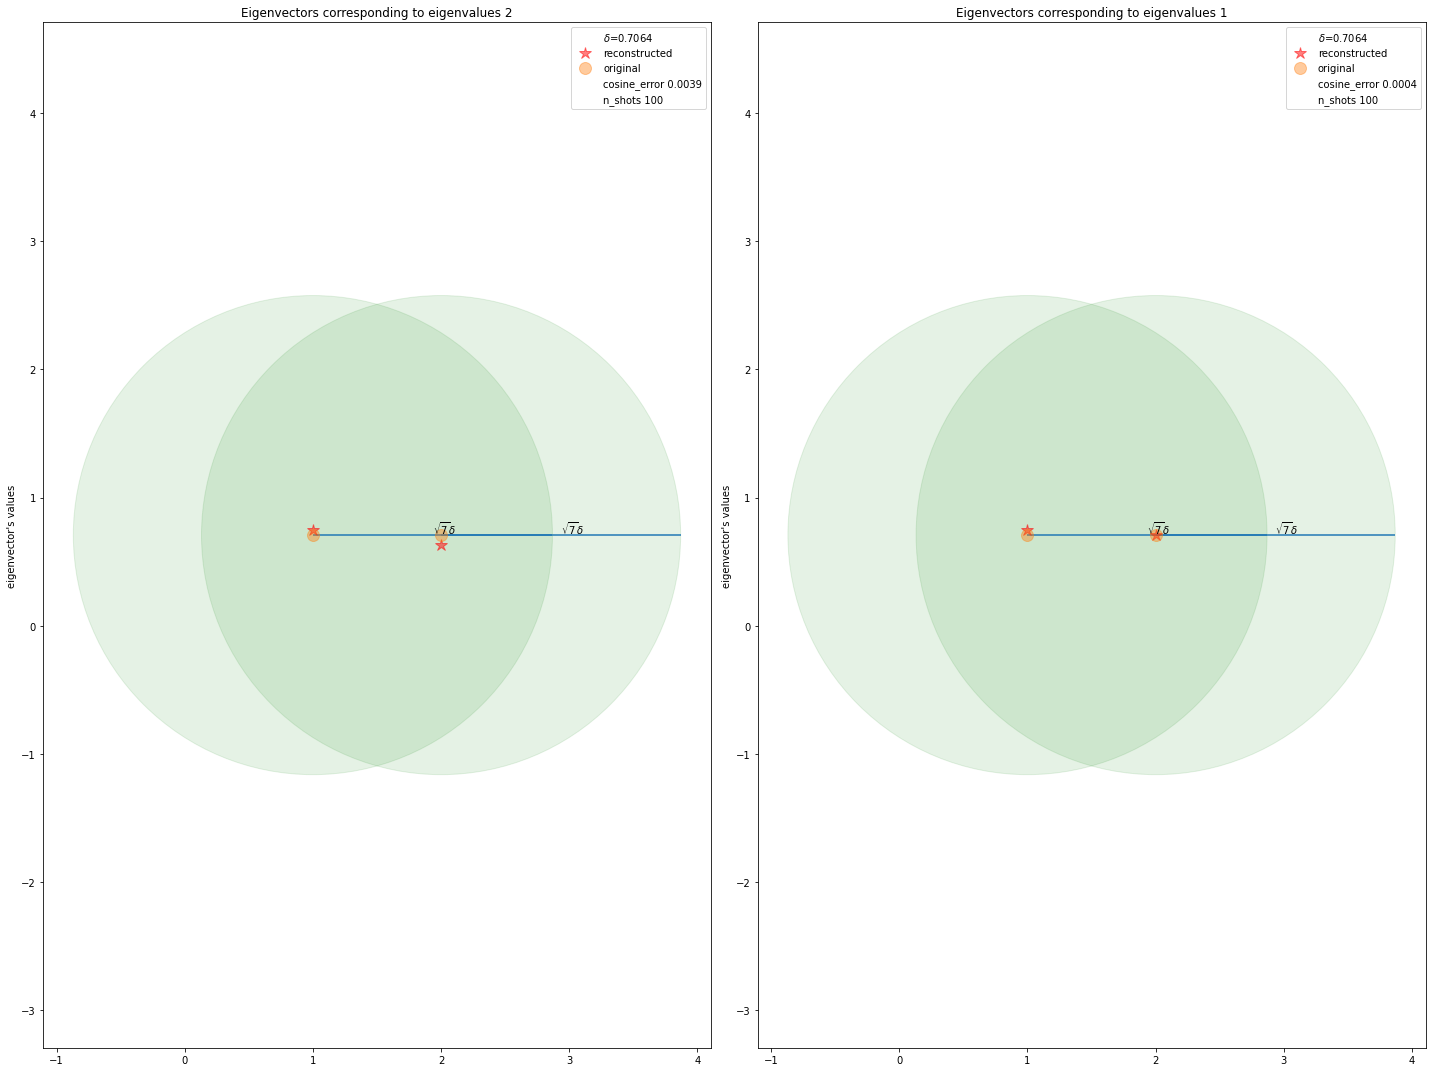

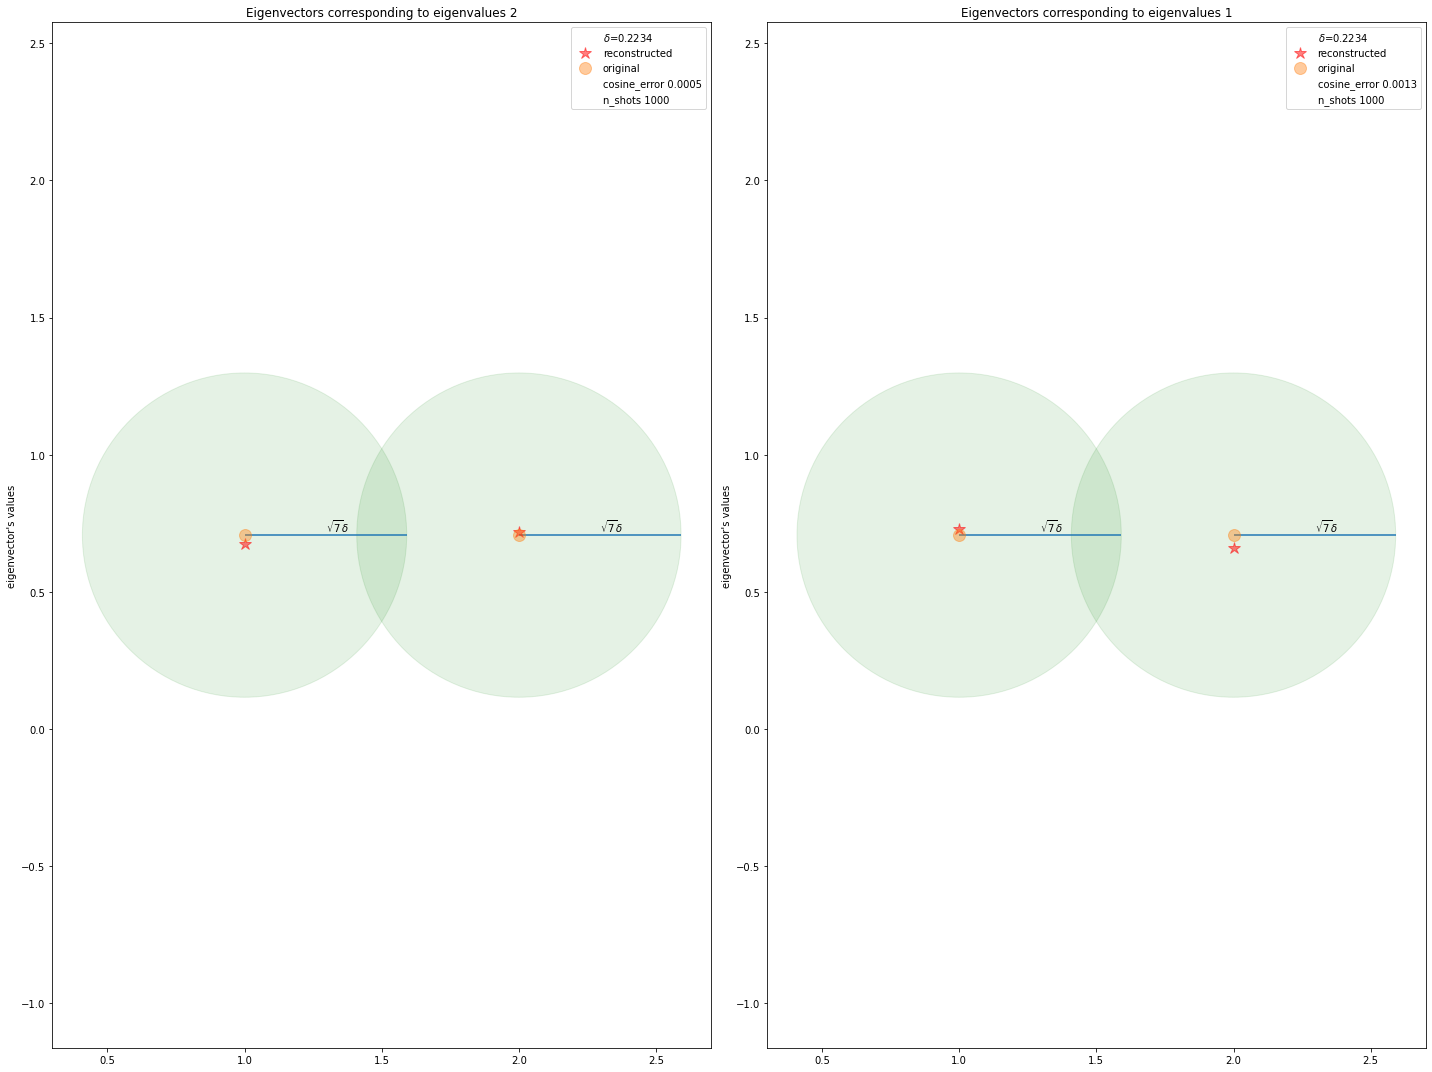

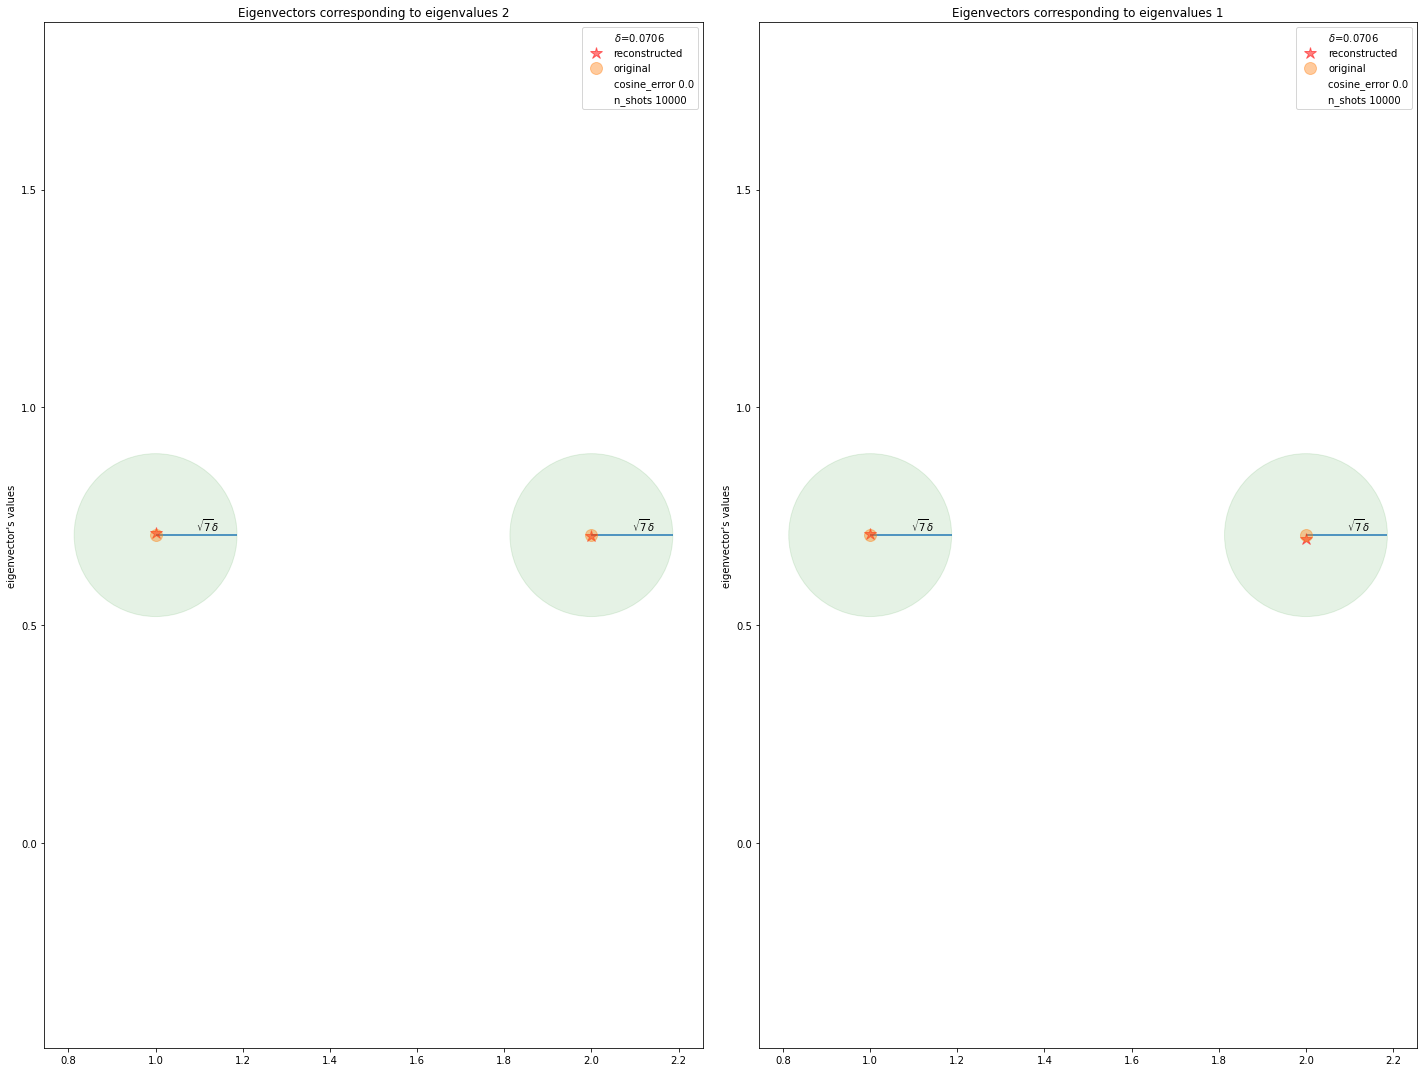

In [7]:
error_list=[]
delta_list=[]

for s in shots_numbers:
    reconstructed_eigenvectors=qpca.eigenvectors_reconstruction(n_shots=s,n_repetitions=3)
    
    eig_evec_tuple,delta=qpca.spectral_benchmarking(eigenvector_benchmarking=True, eigenvalues_benchmarching=False,print_distances=True,only_first_eigenvectors=False,plot_delta=True,distance_type='cosine')
    error_list.append(eig_evec_tuple)
    delta_list.append(delta)


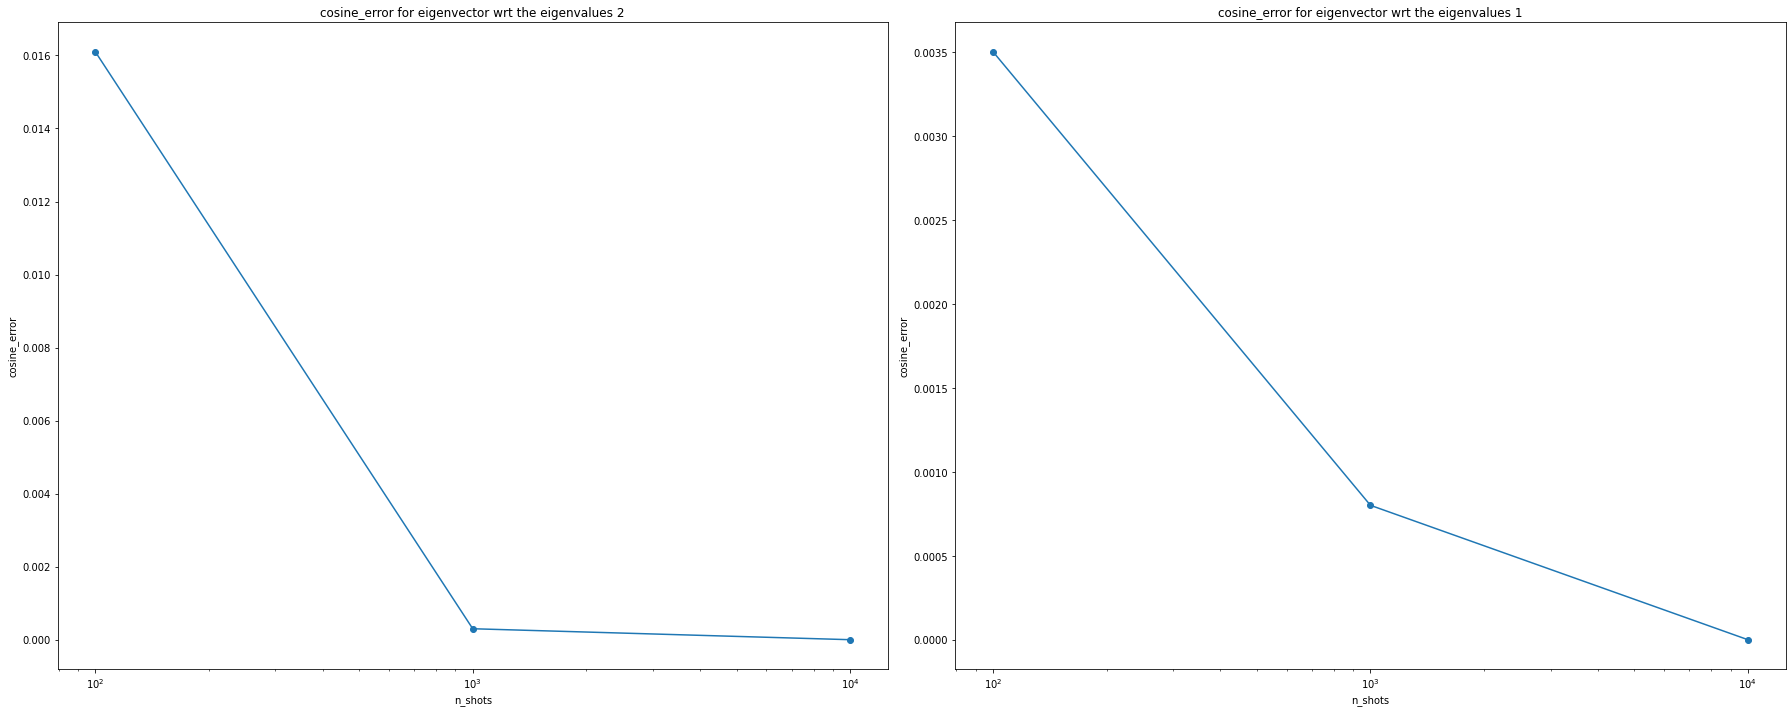

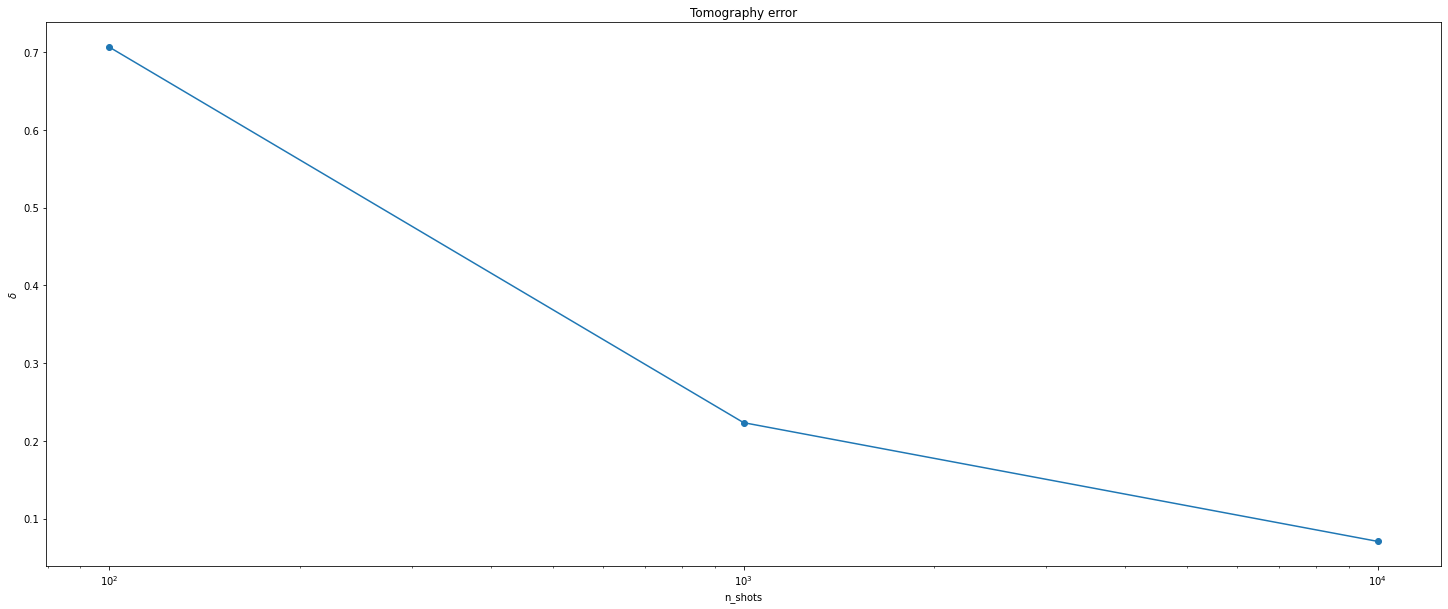

In [17]:
qpca.error_benchmarking(shots_list=shots_numbers,n_tomography_repetitions=1,plot_delta=True,distance_type='cosine')

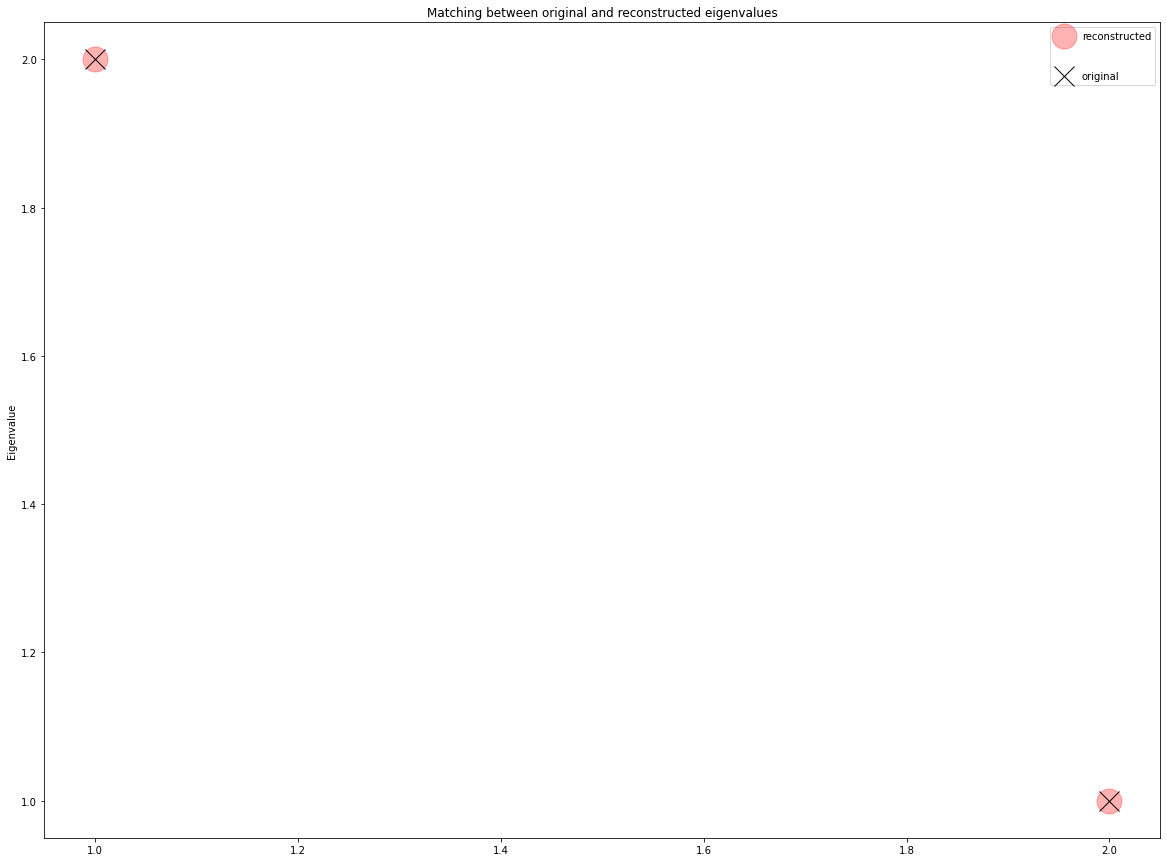

In [9]:
qpca.spectral_benchmarking(eigenvector_benchmarking=False,eigenvalues_benchmarching=True,print_distances=True,only_first_eigenvectors=False,plot_delta=True,distance_type='l2')

In [ ]:
'''error_list=[]
delta_list=[]

for s in shots_numbers:
    reconstructed_eigenvectors=qpca.eigenvectors_reconstruction(n_shots=s,n_repetitions=3)
    #reconstructed_eigenvectors=qpca.eigenvectors_reconstruction()
    eig_evec_tuple,delta=qpca.eigenvectors_benchmarking(plot_delta=True,only_first_eigenvectors=False,distance_type='l2')
    error_list.append(eig_evec_tuple)
    delta_list.append(delta)
'''

## Da cancellare

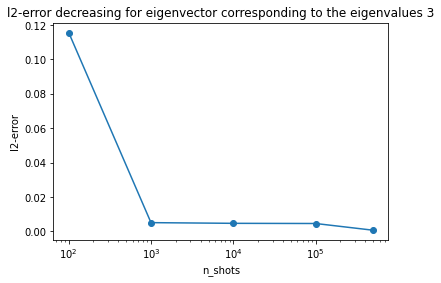

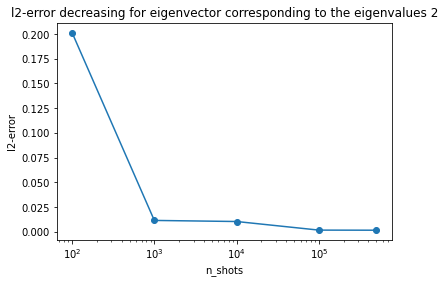

In [12]:
for key in dict_:
    
    plt.plot(shots_numbers,dict_[key],'-o')
    plt.xticks(shots_numbers)
    plt.xscale('log')
    plt.xlabel('n_shots')
    plt.ylabel('l2-error')
    plt.title('l2-error decreasing for eigenvector corresponding to the eigenvalues {}'.format(key))
    plt.show()

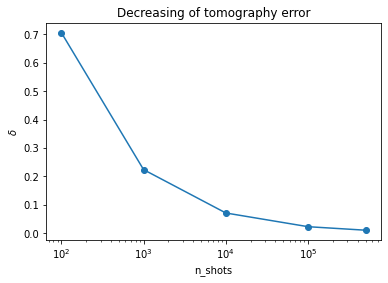

In [13]:
plt.plot(shots_numbers,delta_list,'-o')
plt.xticks(shots_numbers)
plt.xscale('log')
plt.xlabel('n_shots')
plt.ylabel(r'$\delta$')
plt.title(r'Decreasing of tomography error')
plt.show()

In [ ]:
l2_list=[]
delta_list=[]
for s in measure_indexes:
  
    reconstructed_statevector=qpca.state_vector_tomography(n_shots=s)
    reconstructed_eigenvectors=qpca.eigenvectors_reconstruction()
    l2_error,delta_error=qpca.l2_norm_benchmark(plot_delta=True)
    delta_list.append(delta_error)
    l2_list.append(l2_error[0])
    
eigenvalue=np.unique([l[0] for l in l2_list])
l2_errors=[l[1] for l in l2_list]

eigenvalue,l2_errors

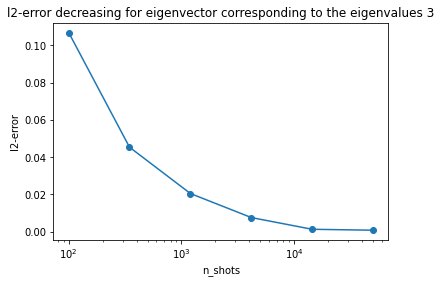

In [12]:
plt.plot(measure_indexes,l2_errors,'-o')
plt.xticks(measure_indexes)
plt.xscale('log')
plt.xlabel('n_shots')
plt.ylabel('l2-error')
plt.title('l2-error decreasing for eigenvector corresponding to the eigenvalues {}'.format(eigenvalue[0]))
plt.show()

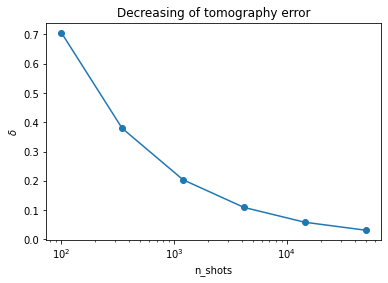

In [13]:
plt.plot(measure_indexes,delta_list,'-o')
plt.xticks(measure_indexes)
plt.xscale('log')
plt.xlabel('n_shots')
plt.ylabel(r'$\delta$')
plt.title(r'Decreasing of tomography error')
plt.show()

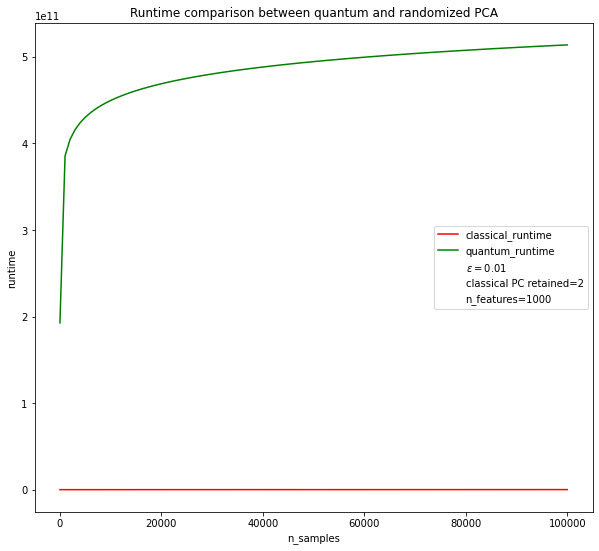

In [13]:
#max_n_samples=10000, n_features=100,classical_principal_components=2,eps=0.01,rand_PCA=False
#max_n_samples=500000, n_features=100,classical_principal_components=2,eps=0.01,rand_PCA=False
#max_n_samples=1000000, n_features=1000,classical_principal_components=2,eps=0.01,rand_PCA=True
#max_n_samples=10000000, n_features=1000,classical_principal_components=2,eps=0.01,rand_PCA=True
#max_n_samples=10000000, n_features=10000,classical_principal_components=2,eps=0.01,rand_PCA=True

qpca.runtime_comparison(max_n_samples=100000, n_features=1000,classical_principal_components=2,eps=0.01,rand_PCA=True)

In [170]:
#n, m = np.meshgrid(np.linspace(50, 100000, dtype=np.int64, num=100),np.linspace(5, 500, dtype=np.int64, num=100))
n=np.linspace(50, 100000, dtype=np.int64, num=100)
m_=[10,100,1000,10000,100000]
k=2
eps=0.01
#print(measure_indexes)
shot=measure_indexes[-1]
print(shot)
def runtime_comparison(max_n_samples, n_features,classical_principal_components,eps,shots):
    n=np.linspace(50, max_n_samples, dtype=np.int64, num=100)
    
    classical_rand_complexity=n*n_features*np.log(classical_principal_components)

    delta=np.sqrt((36*n_features*np.log(n_features))/shots)
    #print(delta)
    martrix_encoding_complexity=np.log(n*n_features)
    pe_complexity=(np.linalg.cond(input_matrix)/eps)*(1/eps)*np.log(n*n_features)
    tomography_complexity=n_features/(delta**2)
    #print('tomo.',tomography_complexity)

    total_complexity=martrix_encoding_complexity+pe_complexity+tomography_complexity
    #print(total_complexity)
    # Base plot
    fig, ax = plt.subplots(figsize=[10,9])

    plt.plot(n,classical_rand_complexity,color='red',label='classical_runtime')
    plt.plot(n,total_complexity,color='green',label='quantum_runtime')
    plt.xlabel('n_samples')
    plt.ylabel('runtime')
    #plt.title('Number of features: '+str(n_features))
    idx_ = np.argwhere(np.diff(np.sign(classical_rand_complexity-total_complexity))).flatten()
    #print(idx_)
    if len(idx_)>0:
        #Zoomed plot
        n_zoomed=np.linspace(50, n[idx_][0]+2000, dtype=np.int64, num=100)
        classical_complexity2=n_zoomed*n_features*np.log(classical_principal_components)
        quantum_complexity_2=np.log(n_zoomed*n_features)+(np.linalg.cond(input_matrix)/eps)*(1/eps)*np.log(n_zoomed*n_features)+n_features/(delta**2)
        
        #find intersection of two zoomed line
        idx = np.argwhere(np.diff(np.sign(classical_complexity2-quantum_complexity_2))).flatten()

        ax2 = plt.axes([.65, .3, .2, .2])
        plt.plot(n_zoomed,quantum_complexity_2,color='green')
        plt.plot(n_zoomed,classical_complexity2,color='red')
        ax2.vlines(n_zoomed[idx],ymin=0,ymax=classical_complexity2[idx],linestyle='--',color='black',alpha=0.3)
        plt.setp(ax2,xticks=[],yticks=[])
        ax2.set_xticks(n_zoomed[idx])
        ax2.set_yticks(classical_complexity2[idx])
        #ax2.yaxis.get_major_locator().set_params(nbins=3)
        #ax2.xaxis.get_major_locator().set_params(nbins=3)
        #x1, x2, y1, y2 = .65, .6, .2, 2
        #ax2.set_xlim(x1, x2)
        #ax2.set_ylim(y1, y2)

        #plt.xticks(visible=True)
        #plt.yticks(visible=True)

        mark_inset(ax, ax2, loc1=2, loc2=4, fc="none", ec="0.7",linestyle='--')
    ax.legend()
    plt.show()

'''
import seaborn as sns
fig , ax = plt.subplots(figsize=(8, 6))
#ax.set_xticks(range(len(n))) # <--- set the ticks first
#ax.set_xticklabels(n)
#plt.figure()
sns.heatmap(g, cmap='RdYlGn',yticklabels=np.linspace(50,100000,10,dtype=np.int))
#ax.set_yticks(list(range(100)))

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
figure(num=None, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')
cmap = clrs.ListedColormap(['blue', 'green'])
#plt.yticks(, ["True","False"])

plt.scatter(x = n, y= m, c=(g == True).astype(float), cmap=cmap,s=200)#plt.cm.get_cmap('RdBu'))'''

50000


'\nimport seaborn as sns\nfig , ax = plt.subplots(figsize=(8, 6))\n#ax.set_xticks(range(len(n))) # <--- set the ticks first\n#ax.set_xticklabels(n)\n#plt.figure()\nsns.heatmap(g, cmap=\'RdYlGn\',yticklabels=np.linspace(50,100000,10,dtype=np.int))\n#ax.set_yticks(list(range(100)))\n\nfrom matplotlib.pyplot import figure\nimport matplotlib.pyplot as plt\nimport matplotlib.colors as clrs\nfigure(num=None, figsize=(20,10), dpi=80, facecolor=\'w\', edgecolor=\'k\')\ncmap = clrs.ListedColormap([\'blue\', \'green\'])\n#plt.yticks(, ["True","False"])\n\nplt.scatter(x = n, y= m, c=(g == True).astype(float), cmap=cmap,s=200)#plt.cm.get_cmap(\'RdBu\'))'

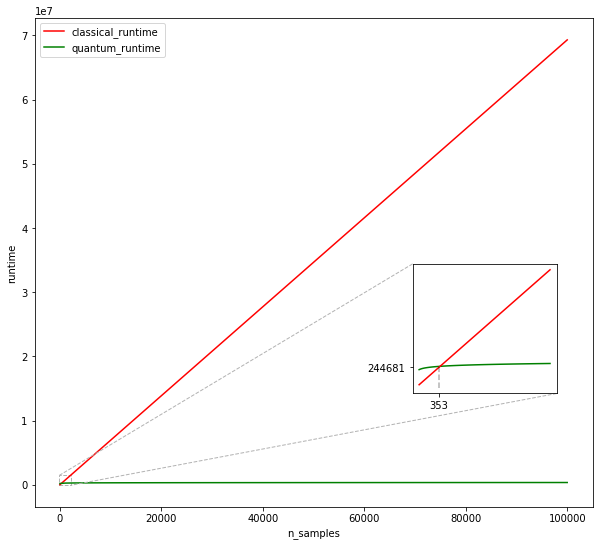

In [174]:
runtime_comparison(max_n_samples=100000,n_features=1000,classical_principal_components=2,eps=0.01,shots=measure_indexes[-1])